# Massachusetts is #1 in Education, not Florida

I was rage-baited by this [article](https://www.usnews.com/news/best-states/articles/2024-05-07/why-florida-is-the-best-state-in-education-and-economy) from U.S. News & World Report, which makes sweeping claims about Florida being the top state in both education and the economy. Adding to the hype were two celebratory press releases from Governor Ron DeSantis, [here](https://www.flgov.com/eog/news/press/2025/governor-ron-desantis-announces-positive-achievements-2025-school-grades) and [here](https://flgov.com/eog/news/press/2025/governor-ron-desantis-announces-student-academic-performance-continues-rise-during), touting supposed gains in Florida’s education system.

However, these claims rest almost entirely on state controlled assessments, where the state determines the content and standards. This raises valid concerns about the objectivity of the data being reported. A more reliable approach would be to examine trends in national standardized assessments, which offer consistent, independent measures across all states. When doing so, a very different picture emerges: Florida’s educational performance has, like much of the nation, declined over time. In contrast, Massachusetts consistently outperforms the rest of the country across nearly every national benchmark highlighting what genuine educational excellence looks like.

Note: It's clear that the U.S. News & World Report article bases much of its education ranking on factors like the cost of higher education and graduation rates from two and four year colleges, metrics that are, frankly, questionable indicators of educational quality. Tuition costs alone are a poor measure without accounting for post-graduation outcomes. As U.S. News should already know from its own college rankings, return on investment, such as graduates’ average earnings, is a far more meaningful metric.

Moreover, graduation rates don’t necessarily reflect academic strength. In some cases, unusually high graduation rates may raise concerns about the rigor and standards of the curriculum, rather than serve as evidence of educational excellence.

### Load the data and requisite packages

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import scipy

import utils.scores as scores
import utils.anomaly as anomaly
import utils.us_map

In [18]:
states = utils.us_map.main()

paths = ["data/naep/NDECoreExcel_Reading, Grade 8, All students_20250815065213.xlsx",
         "data/naep/NDECoreExcel_Reading, Grade 4, All students_20250815065450.xlsx",
         "data/naep/NDECoreExcel_Mathematics, Grade 8, All students_20250815065004.xlsx",
         "data/naep/NDECoreExcel_Mathematics, Grade 4, All students_20250815065347.xlsx"]

naep_scores = scores.Scores()
for path in paths:
    naep_scores = naep_scores.merge(scores.NAEPScores(path))

In [19]:
s1 = scores.SATScores("data/sat/tabn226.40_17_18_19_20.xlsx")
s2 = scores.SATScores("data/sat/tabn226.40_18_21_22_23.xlsx")
s2.df = s2.df.query("year!=2018")

paths = ['data/act/tabn226.60_2013_2017.xlsx',
         'data/act/tabn226.60_2014_2018.xlsx',
         'data/act/tabn226.60_2015_2019.xlsx',
         'data/act/tabn226.60_2016_2020.xlsx',
         'data/act/tabn226.60_2017_2021.xlsx',
         'data/act/tabn226.60_2018_2022.xlsx',
         'data/act/tabn226.60_2018_2023.xlsx']

objs = [scores.ACTScores(path) for path in paths]
objs[0].df = objs[0].df.query("year==2013")
objs[1].df = objs[1].df.query("year==2014")

test_scores = scores.Scores()

for score in [s1, s2] + objs:
    test_scores = test_scores.merge(score)

# NAEP Scores

The National Assessment of Educational Progress (NAEP) periodically administers standardized tests in reading and mathematics to 4th and 8th graders nationwide. One of its strengths lies in its rigorous, representative sampling methods, which enable meaningful comparisons across states. As shown in the charts below, Florida performs impressively in 4th grade math and reading, ranking among the top 10 states in 2024. However, by 8th grade, the state’s performance drops sharply, landing near the bottom in both subjects. This suggests that Florida's strong early academic achievement is not sustained through middle school, and as I will demonstrate later, this trend continues into high school.

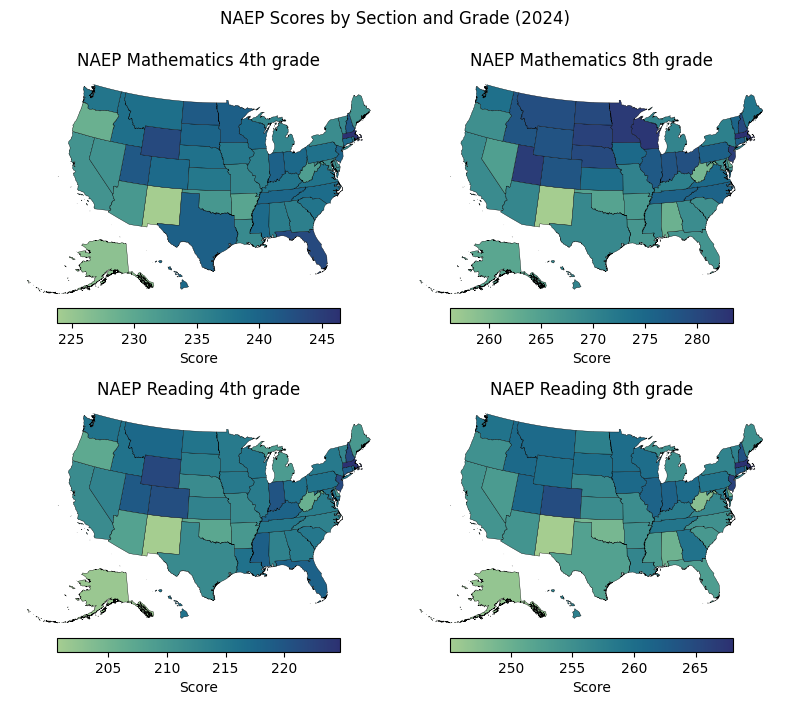

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), layout="tight")
axes = axes.flatten()
[ax.set_axis_off() for ax in axes]
min_value = naep_scores.get_year(2024).df["mean"].min()
max_value = naep_scores.get_year(2024).df["mean"].max()

for section, ax in zip(sorted(naep_scores.df["section"].unique()), axes):
    df = naep_scores.get_year(2024).get_section(section).df
    label = "NAEP " + " ".join(section.split("_")) + "th grade"
    ax.set_title(f"{label}")
    map = (states.merge(df,
                        right_on="location", left_on="NAME")
           .plot(column="mean",
                 cmap="crest",
                 legend=True,
                 edgecolor="black",
                 lw=0.25,
                 legend_kwds={"label": "Score",
                              "shrink": 0.75,
                              "orientation": "horizontal",
                              "pad": 0.01
                              },
                 ax=ax))

fig.suptitle("NAEP Scores by Section and Grade (2024)", y=0.88)
plt.show()

To more easily assess the total academic performance between 4th and 8th graders, the sum of individual NAEP tests were summed into a single aggregate score. Massachusetts clearly is #1 in terms of NAEP performance out of all states. In a separate figure, a time series of total NAEP scores are displayed for Massachusetts, Florida, and the national average. As noted by many sources, academic performance on the NAEP has declined across the country for many years and is a cause for concern in our national's educational efforts. Florida has not been immune to this trend. In a table showing the total NAEP scores by state, Florida ranks 26th in 2024. 

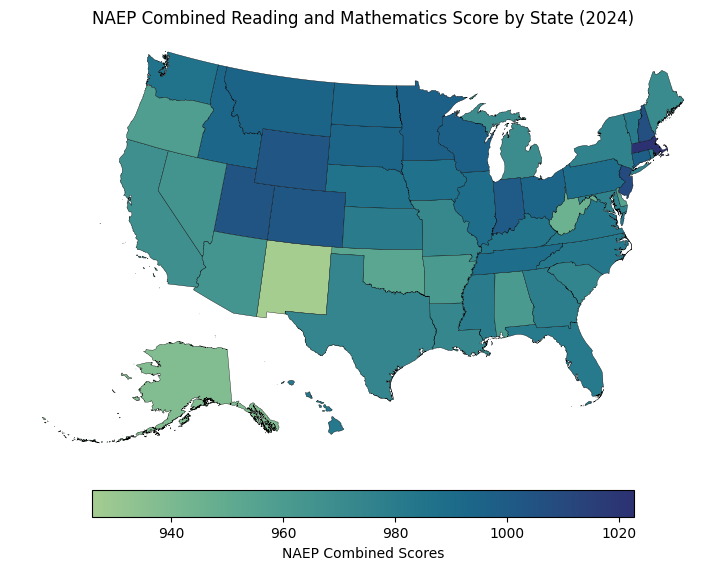

In [21]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_axis_off()

combined_scores_df = naep_scores.df.groupby(
    ["year", "location"]).agg(total=("mean", "sum")).reset_index()

(states.merge(combined_scores_df.query("year==2024"),
              left_on="NAME",
              right_on="location")
 .plot(column="total",
       cmap="crest",
       legend=True,
       edgecolor="black",
       lw=0.25,
       legend_kwds={"label": "NAEP Combined Scores",
                    "shrink": 0.5,
                    "orientation": "horizontal",
                    "pad": 0.05
                    },
       ax=ax
       )
 )

plt.title("NAEP Combined Reading and Mathematics Score by State (2024)")
plt.show()

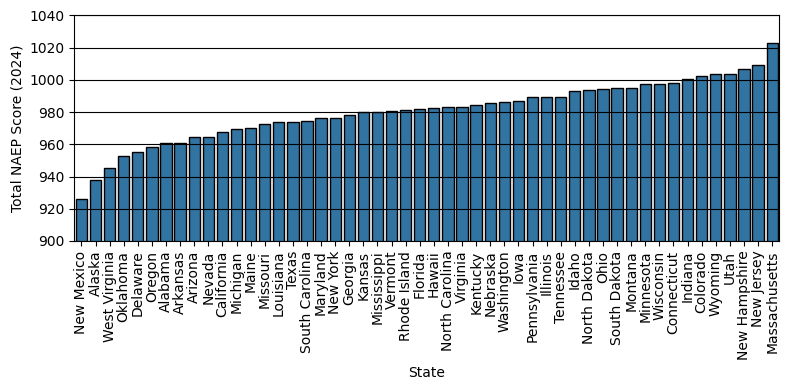

In [88]:
non_states = ["DoDEA", "Puerto Rico", "District of Columbia", "National"]
barplot_df = (combined_scores_df.query("year==2024")
              .query("location not in @non_states")
              .sort_values("total").
              reset_index(drop=True))

fig, ax = plt.subplots(figsize=(8,4), layout="tight")

sns.barplot(data=barplot_df,
            x=barplot_df.index,
            y="total",
            edgecolor="black")
plt.grid(color="black", axis="y")
ax.set_xticks(barplot_df.index)
ax.set_xticklabels(barplot_df["location"], rotation=90)
ax.set_ylabel("Total NAEP Score (2024)")
ax.set_xlabel("State")
plt.ylim([900, 1040])
plt.show()


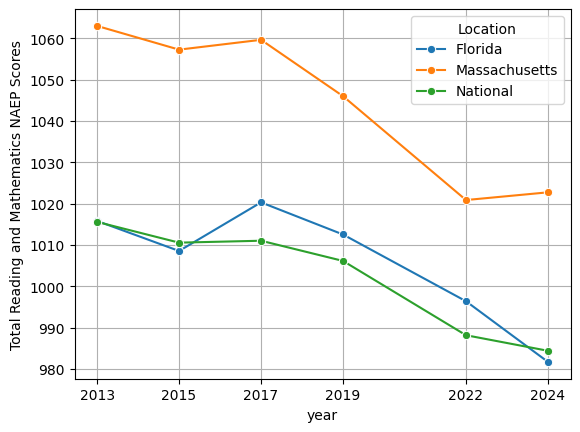

In [22]:
compare = ["Massachusetts", "Florida", "National"]
sns.lineplot(data=combined_scores_df.query("location in @compare"),
             x="year",
             y="total",
             hue="location",
             marker="o",
             )
plt.ylabel("Total Reading and Mathematics NAEP Scores")
plt.xticks([2013, 2015, 2017, 2019, 2022, 2024])
plt.legend(title="Location")
plt.grid()
plt.show()

In [23]:
non_states = ["DoDEA", "Puerto Rico", "District of Columbia", "National"]

rankings = (combined_scores_df.query("location not in @non_states")
            .pivot_table(index="location", columns="year", values="total")
            .sort_values(2024, ascending=False)
            .reset_index()
            )

rankings.columns.name = "2024 Rankings"
rankings.index = rankings.index + 1
rankings.round(1)

2024 Rankings,location,2013,2015,2017,2019,2022,2024
1,Massachusetts,1063.0,1057.2,1059.6,1046.0,1020.9,1022.7
2,New Jersey,1048.0,1039.1,1047.5,1035.3,1012.6,1009.4
3,New Hampshire,1055.0,1050.3,1042.3,1024.0,1003.7,1006.7
4,Utah,1020.0,1024.3,1023.2,1021.3,1008.1,1003.9
5,Wyoming,1031.5,1030.4,1032.4,1023.5,1009.6,1003.6
6,Colorado,1034.3,1019.2,1022.0,1018.7,997.6,1002.7
7,Indiana,1029.0,1030.4,1032.7,1018.3,995.7,1000.3
8,Connecticut,1032.7,1026.1,1024.3,1023.5,995.8,998.0
9,Wisconsin,1021.8,1025.3,1017.5,1017.4,1001.0,997.3
10,Minnesota,1046.1,1037.3,1035.9,1025.4,995.0,997.3


# College Admissions Tests

Each year, countless high school students rise early and head to testing centers across the country, ready to prove their college readiness through standardized exams like the SAT and ACT. These tests provide colleges with a consistent benchmark to assess applicants nationwide—one that isn’t influenced by local curriculum differences or [grade inflation](https://eric.ed.gov/?id=ED621326). In the absence of recent nationwide 12th-grade testing through the NAEP, these exams offer a valuable tool for comparing academic performance across state lines. We use data from the National Center for Education Statistics (NCES) which collect the testing results by state.

### Participtation Rates Skew Results
However, the landscape of standardized testing is far from uniform. The ACT has traditionally dominated in the Midwest, while the SAT remains more common along the East and West Coasts. This geographic divide introduces complications. In states where a test isn't widely taken, participation is typically limited to high-achieving students aiming to stand out which skews the results. As a result, SAT scores tend to appear inflated in ACT-heavy states, and vice versa for ACT scores in SAT-dominant regions. Understanding these patterns is essential when using test scores to compare student performance across the country.

/Users/robertli/Documents/misc/education/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


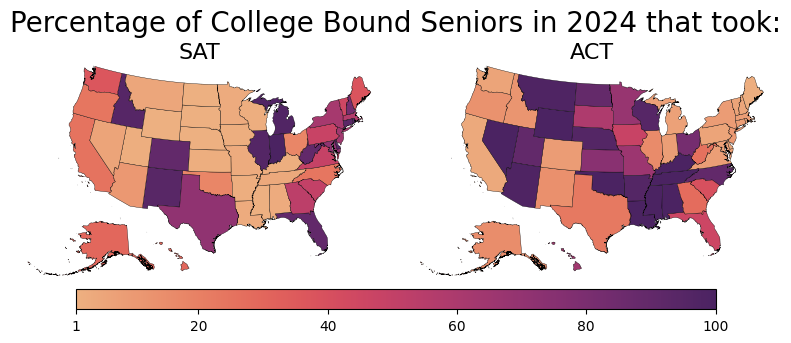

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), layout="tight")

ax = ax.flatten()
[a.set_axis_off() for a in ax]

vmin = test_scores.get_year(2023).df["percent"].min()
vmax = test_scores.get_year(2023).df["percent"].max()
cmap = "flare"

(states.merge(test_scores.get_year(2023).get_section("total").query("test=='SAT'").df,
              left_on="NAME",
              right_on="location")
 .plot(column="percent", cmap=cmap, vmin=vmin,
       vmax=vmax, edgecolor="black", lw=0.25,
       ax=ax[0])
 )
ax[0].set_title("SAT", fontsize=16, y=0.95)

(states.merge(test_scores.get_year(2023).get_section("composite").query("test=='ACT'").df,
              left_on="NAME",
              right_on="location").plot(column="percent", cmap=cmap, vmin=vmin, vmax=vmax, edgecolor="black",
                                        lw=0.25, ax=ax[1])
 )
ax[1].set_title("ACT", fontsize=16, y=0.95)

mappable = cm.ScalarMappable(norm=mcolors.Normalize(vmin, vmax), cmap=cmap)
cbar = fig.colorbar(mappable, fig.add_axes(
    [0.1, 0.1, 0.8, 0.05]), orientation="horizontal")
cbar.set_ticks([vmin, 20, 40, 60, 80, vmax])

plt.suptitle(
    "Percentage of College Bound Seniors in 2024 that took:", y=0.85, fontsize=20)
plt.show()

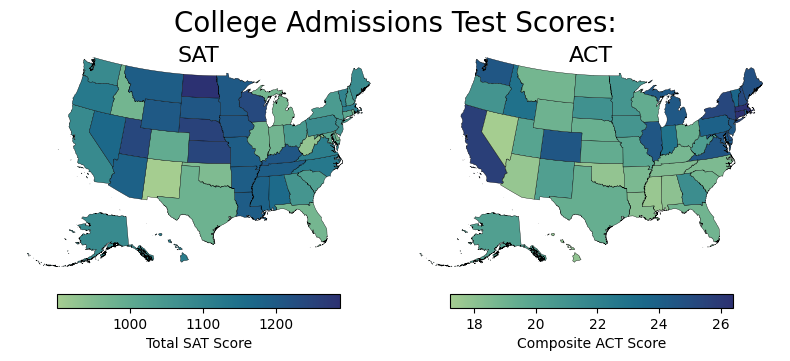

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), layout="tight")

ax = ax.flatten()
[a.set_axis_off() for a in ax]
cmap = "crest"

(states.merge(test_scores.get_year(2023).get_section("total").query("test=='SAT'").df,
              left_on="NAME",
              right_on="location")
 .plot(column="mean", cmap=cmap, edgecolor="black",
       lw=0.25, legend=True, ax=ax[0],
       legend_kwds={"label": "Total SAT Score",
                    "shrink": 0.75,
                    "orientation": "horizontal",
                    "pad": 0.05
                    }
       )
 )
ax[0].set_title("SAT", fontsize=16, y=0.90)

(states.merge(test_scores.get_year(2023).get_section("composite").query("test=='ACT'").df,
              left_on="NAME",
              right_on="location")
 .plot(column="mean", cmap=cmap, edgecolor="black",
       lw=0.25, legend=True, ax=ax[1],
       legend_kwds={"label": "Composite ACT Score",
                    "shrink": 0.75,
                    "orientation": "horizontal",
                    "pad": 0.05
                    }
       )
 )
ax[1].set_title("ACT", fontsize=16, y=0.90)

plt.suptitle("College Admissions Test Scores:", y=0.875, fontsize=20)
plt.show()

### A Relationship Exists between Particpitation Rates and Scores

In the plot below, a state's percent participtation in the SAT or ACT by high school seniors is plotted against the average SAT or ACT score in that state, respectively. The data span multiple years between 2013-2023 for the ACT and 2017-2023 for the SAT. Clearly, a relationship exists between participation rates and the average score in a state. 

The question is now how to minimize this discrepancy between states with varying participating rates in the SAT and ACT? One strategy is to convert ACT scores to SAT scores in states whose students favor the ACT. This way, we can more objectively see the performance of the average student on college admissions testing. An official conversion exists between the ACT and SAT based on concordance studies. However, the official conversion only records discrete ACT scores while the average ACT scores include decimals. A line of best fit was used to smooth the conversion table as shown below to better interpolate the ACT scores. 

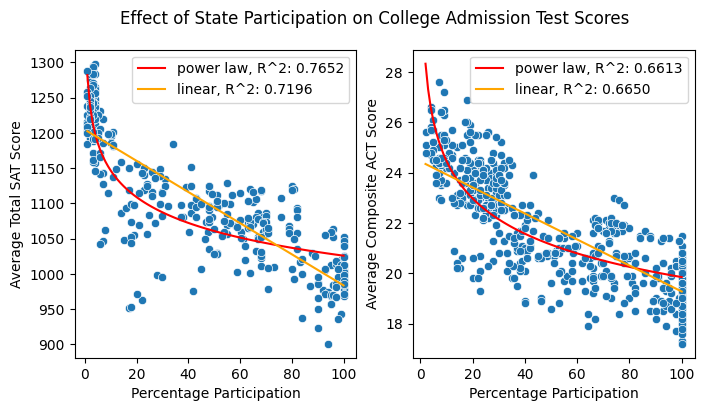

In [132]:
def custom_anomaly(scores, ax):
    def regress(df, func):
        coeffs, pred = anomaly.fit(df["percent"], df["mean"], func)
        r2 = anomaly.calculate_r2(df["mean"], pred)
        return coeffs, pred, r2

    def plot(df, coeffs, r2, ax):
        lin_coeffs, plaw_coeffs = coeffs
        lin_r2, plaw_r2 = r2

        sns.scatterplot(data=df,
                        x="percent",
                        y="mean",
                        ax=ax)

        x = np.linspace(df["percent"].min(), df["percent"].max(), num=100)
        ax.plot(x, anomaly.plaw(x, *plaw_coeffs), color="red")
        ax.plot(x, anomaly.linear(x, *lin_coeffs), color="orange")

        h = [Line2D([0], [0], color="red", label=f"power law, R^2: {plaw_r2:.4f}"),
             Line2D([0], [0], color="orange", label=f"linear, R^2: {lin_r2:.4f}")]
        ax.legend(handles=h)
        ax.set_ylabel("Average Score")
        ax.set_xlabel("Percentage Participation")
        return fig

    def apply(df, ax):
        lin_coeffs, lin_pred, lin_r2 = regress(df, anomaly.linear)
        plaw_coeffs, plaw_pred, plaw_r2 = regress(df, anomaly.plaw)
        return plot(df, (lin_coeffs, plaw_coeffs), (lin_r2, plaw_r2), ax)

    return apply(scores, ax=ax)


fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

custom_anomaly(test_scores.query("test=='SAT'").get_section("total").df, ax[0])
custom_anomaly(test_scores.query("test=='ACT'").get_section("composite").df, ax[1])
ax[0].set_ylabel("Average Total SAT Score")
ax[1].set_ylabel("Average Composite ACT Score")
plt.suptitle("Effect of State Participation on College Admission Test Scores")
plt.show()

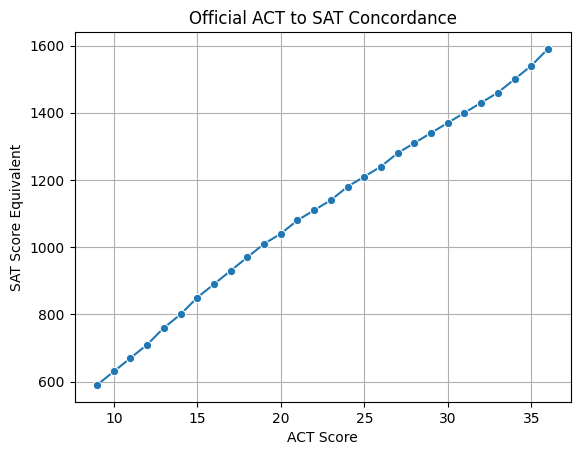

In [133]:
act_sat_conv = pd.read_excel("data/act_sat_conversion.xlsx", skiprows=1).sort_values("ACT")

def act_to_sat(x):
    return np.interp(x, act_sat_conv["ACT"], act_sat_conv["SAT"])

sns.lineplot(data=act_sat_conv,
             x="ACT",
             y="SAT",
             marker="o")

plt.ylabel("SAT Score Equivalent")
plt.xlabel("ACT Score")
plt.title("Official ACT to SAT Concordance")
plt.grid()
plt.show()

Even after converting ACT scores to their SAT equivalents in states where the ACT is more commonly taken, the underlying pattern remains. The effect persists largely due to states where only a small percentage of students take either test. Participation in college admissions exams has declined significantly, especially after many colleges adopted test optional policies in response to the COVID-19 pandemic. For instance, in 2021, only 17% of Oregon students took the SAT, while just 20% took the ACT. Similarly, in California in 2022, only 21% of students sat for the SAT, and a mere 4% took the ACT. This reduced participation increases sampling bias, making it harder to draw accurate comparisons across states.

To address this bias, we propose comparing states based on their deviation from predicted performance. Specifically, we calculate the difference between each state’s actual performance and the expected performance at its level of test participation, represented by the orange trend line in the plot below. If a state (shown as a blue dot) appears above the orange line, it is performing better than average for its level of participation. Conversely, if a state falls below the line, it is underperforming relative to the expected outcome at that participation rate. 

Note: A new line is fitted for each year to achieve better predictions although the plots are not shown. 

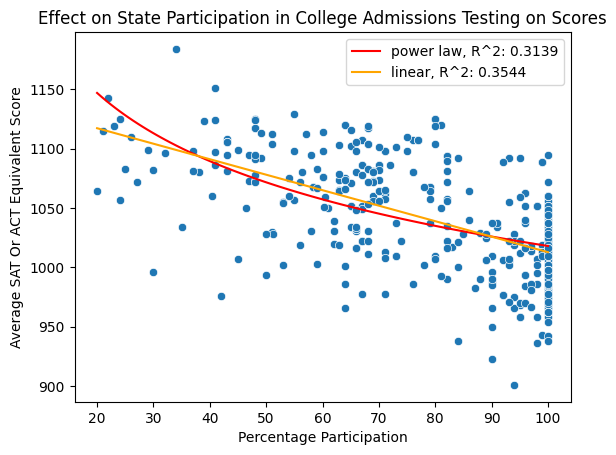

In [134]:
act_scores = test_scores.get_section("composite").df
act_scores_conv_df = act_scores.assign(SAT_equiv=act_to_sat(act_scores["mean"]))
                                       
sat_scores = test_scores.get_section("total").df
combined_scores = (sat_scores.merge(act_scores_conv_df, on=["location", "year"])
                             .rename({"percent_x": "SAT_percent",
                                      "mean_x": "SAT_mean",
                                      "percent_y": "ACT_percent"}, axis=1))

majority_mean = np.where(combined_scores["ACT_percent"] > combined_scores["SAT_percent"],
                         combined_scores["SAT_equiv"],
                         combined_scores["SAT_mean"])

majority_percent = np.where(combined_scores["ACT_percent"] > combined_scores["SAT_percent"],
                            combined_scores["ACT_percent"],
                            combined_scores["SAT_percent"])

combined_scores = (combined_scores.assign(mean=majority_mean)
                                  .assign(percent=majority_percent))

anomaly.anomaly(combined_scores, separate_years=False)
plt.ylabel("Average SAT Or ACT Equivalent Score")
plt.title("Effect on State Participation in College Admissions Testing on Scores")
combined_corrected_scores = anomaly.anomaly(
    combined_scores, separate_years=True, suppress=True
)
combined_corrected_scores = combined_corrected_scores.assign(
    anom_c=combined_corrected_scores["mean"]-combined_corrected_scores["lin_pred"]
)

After plotting the percentage participtation corrected performance by state, a similar result to the NAEP scores before materializes. Massachusetts comes out on top in the 2023 results while Florida lags behind at 43th. The raw SAT and ACT score tables are included below, but take in mind the sampling bias when interpreting those results. 

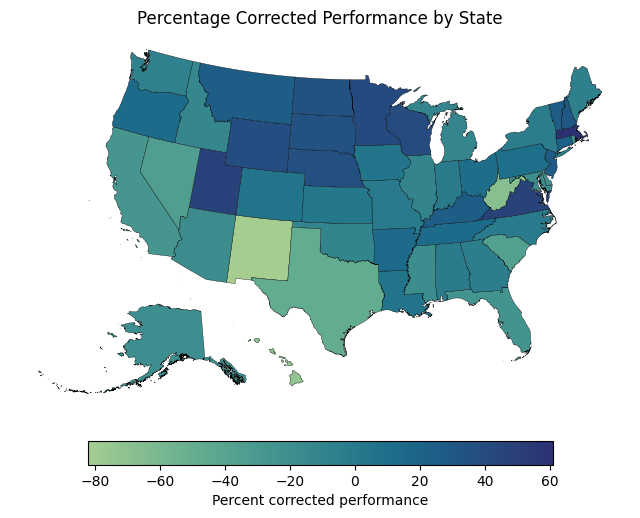

In [135]:
fig, ax = plt.subplots(figsize=(8, 8))

states.merge(combined_corrected_scores.query("year==2023"),
             left_on="NAME",
             right_on="location").plot(column="anom_c", cmap="crest", edgecolor="black",
                                       lw=0.25, legend=True, legend_kwds={"label": "Percent corrected performance",
                                                                          "shrink": 0.75,
                                                                          "orientation": "horizontal",
                                                                          "pad": 0.05
                                                                          },
                                       ax=ax)

plt.title("Percentage Corrected Performance by State")
ax.set_axis_off()

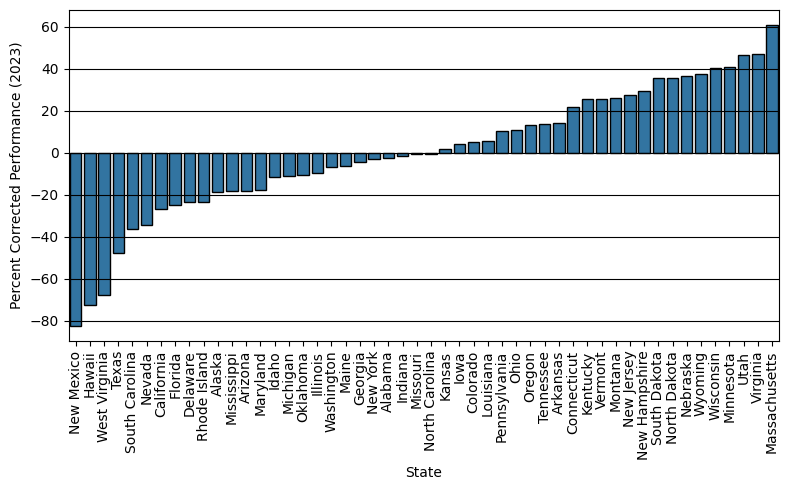

In [157]:
non_states = ["District of Columbia", "United States"]
barplot_df = (combined_corrected_scores.query("year==2023")
              .query("location not in @non_states")
              .sort_values("anom_c").
              reset_index(drop=True))
barplot_df

fig, ax = plt.subplots(figsize=(8,5), layout="tight")

sns.barplot(data=barplot_df,
            x=barplot_df.index,
            y="anom_c",
            edgecolor="black")
plt.grid(color="black", axis="y")
ax.set_xticks(barplot_df.index)
ax.set_xticklabels(barplot_df["location"], rotation=90)
ax.set_ylabel("Percent Corrected Performance (2023)")
ax.set_xlabel("State")
plt.show()

### SAT Performance over Time

The previous figures illustrated the performance on college admissions tests nationwide in 2023. To get a better understanding of the overall trends over time, let us focus on SAT scores in Florida where the SAT is taken by a majority of high schoolers. Since low participation can artificially inflate SAT scores, it is important to consider both scores and participation rates together when analyzing trends. The figure below shows average SAT scores over time for Florida and the United States as a whole. Aside from a one time spike in 2021, when the number of test takers dropped precipitously, the overall national trend in SAT scores has been a steady decline.

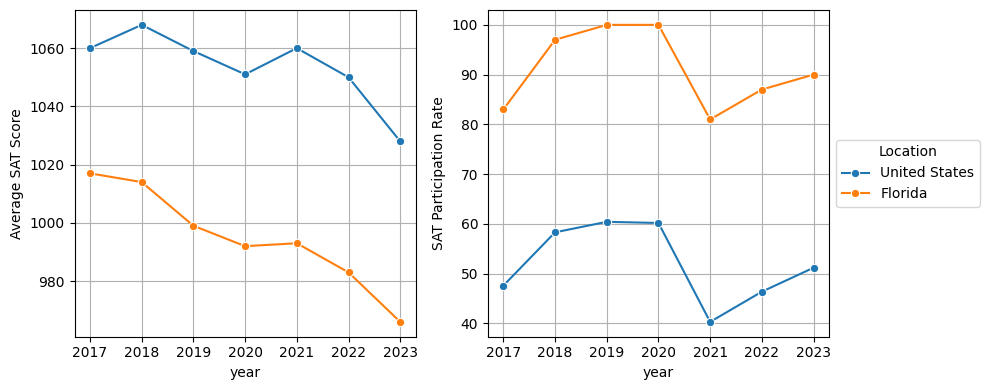

In [142]:
compare = ["Florida", "United States"]

fig, ax = plt.subplots(ncols=2, figsize=(10,4), layout="tight")
sns.lineplot(data=test_scores.get_section("total").get_states(compare).df,
             x="year",
             y="mean",
             hue="location",
             marker="o",
             ax=ax[0])
ax[0].get_legend().remove()
ax[0].set_ylabel("Average SAT Score")
ax[0].grid()

sns.lineplot(data=test_scores.get_section("total").get_states(compare).df,
             x="year",
             y="percent",
             hue="location",
             marker="o",
             ax=ax[1])
ax[1].set_ylabel("SAT Participation Rate")
ax[1].legend(bbox_to_anchor=[1, 0.5], loc="center left", title="Location")
ax[1].grid()
plt.show()

# Conclusion

The educational success of our students is one of the most critical priorities for our nation. To effectively address this challenge, we must look beyond headlines and political narratives and focus on objective indicators that reveal troubling and persistent trends in student achievement. Test scores are declining at every level, from elementary to high school. Rather than sensationalizing underperformance or manipulating state-by-state comparisons to mask the reality, we must confront the root causes of our academic decline. Even historically strong states like Massachusetts, while still outperforming much of the country, are showing signs of struggle when compared to past performance. It is my hope that the data presented here sheds light on the current state of education in the United States and sparks a deeper, more honest conversation about how to move forward.

In [136]:
non_states = ["District of Columbia", "United States"]
combined_corrected_scores_states = combined_corrected_scores.query(
    "location not in @non_states")

rankings = (combined_corrected_scores_states.pivot_table(index="location", columns="year", values="anom_c")
            .sort_values(2023, ascending=False)
            .reset_index())
rankings.columns.name = "2023 Rankings"
rankings.index = rankings.index + 1
rankings.round(1)

2023 Rankings,location,2017,2018,2019,2020,2021,2022,2023
1,Massachusetts,50.3,67.7,71.3,76.1,99.3,68.5,60.8
2,Virginia,33.4,41.2,48.7,48.6,75.1,51.5,47.1
3,Utah,21.3,29.6,34.8,37.8,44.7,38.1,46.3
4,Minnesota,64.3,61.1,66.5,65.7,46.0,43.5,41.0
5,Wisconsin,29.3,33.6,34.8,33.8,33.3,26.6,40.5
6,Wyoming,17.3,13.6,16.8,20.8,21.0,32.6,37.7
7,Nebraska,44.0,17.6,22.8,26.8,20.7,28.3,36.3
8,North Dakota,19.1,22.5,13.1,8.0,26.3,25.7,35.5
9,South Dakota,51.6,45.1,39.3,41.8,39.7,39.6,35.5
10,New Hampshire,16.9,30.4,33.5,33.3,26.8,34.0,29.6


In [137]:
rankings = (combined_corrected_scores_states.pivot_table(index="location", columns="year", values="SAT_mean")
            .sort_values(2023, ascending=False)
            .reset_index())
rankings.columns.name = "2023 Rankings"
rankings.index = rankings.index + 1
rankings.round(1)

2023 Rankings,location,2017,2018,2019,2020,2021,2022,2023
1,North Dakota,1256.0,1283.0,1263.0,1231.0,1258.0,1212.0,1287.0
2,Nebraska,1253.0,1252.0,1260.0,1229.0,1246.0,1222.0,1252.0
3,Kansas,1260.0,1265.0,1241.0,1237.0,1243.0,1238.0,1245.0
4,Utah,1238.0,1230.0,1230.0,1204.0,1238.0,1233.0,1239.0
5,Wisconsin,1291.0,1294.0,1283.0,1243.0,1215.0,1252.0,1236.0
6,Iowa,1275.0,1265.0,1244.0,1220.0,1243.0,1196.0,1208.0
7,South Dakota,1216.0,1241.0,1268.0,1218.0,1215.0,1219.0,1208.0
8,Kentucky,1247.0,1248.0,1232.0,1207.0,1219.0,1219.0,1208.0
9,Minnesota,1295.0,1298.0,1284.0,1257.0,1263.0,1225.0,1201.0
10,Wyoming,1230.0,1257.0,1238.0,1220.0,1233.0,1244.0,1200.0


In [138]:
rankings = (combined_corrected_scores_states.pivot_table(index="location", columns="year", values="mean_y")
            .sort_values(2023, ascending=False)
            .reset_index())
rankings.columns.name = "2023 Rankings"
rankings.index = rankings.index + 1
rankings.round(1)

2023 Rankings,location,2017,2018,2019,2020,2021,2022,2023
1,Connecticut,25.2,25.6,25.5,25.9,27.2,26.3,26.4
2,Massachusetts,25.4,25.5,25.5,26.0,27.6,26.5,26.4
3,California,22.8,22.7,22.6,23.3,26.1,26.5,25.7
4,New York,24.2,24.5,24.5,24.9,26.3,25.3,25.3
5,New Hampshire,25.5,25.1,25.0,25.7,26.6,25.7,25.2
6,Delaware,24.1,23.8,24.0,24.2,25.7,24.9,24.8
7,Maine,24.3,24.0,24.3,24.9,25.6,25.1,24.8
8,Virginia,23.8,23.9,24.0,24.4,25.5,24.6,24.6
9,Maryland,23.6,22.5,22.3,23.8,25.5,24.4,24.5
10,Colorado,20.8,23.9,23.8,23.7,23.6,23.2,24.5


## Acknowledgements

Thank you to Oscar for sharing code on how to [create maps](https://dev.to/oscarleo/how-to-create-data-maps-of-the-united-states-with-matplotlib-p9i) of the US. 